In [219]:
import numpy as np 
import pandas as pd 

import pickle

from tqdm import *

import itertools

import matplotlib.pyplot as plt
%matplotlib inline  

# starts here

In [213]:
from scipy.linalg import expm 
from scipy.linalg import logm 

from scipy.linalg import fractional_matrix_power

def func(X, As): ## this is the Riemannian center of mass function
    
    Xp = fractional_matrix_power(X, -0.5) 
        
    s = 0 
    
    for A in As: 
        
        s = s + np.linalg.norm( logm( np.dot( np.dot( Xp, A ), Xp ) ) )**2

    return s 

In [214]:
def get_min(N, d, As, eta = 0.001): 
    
    change = np.inf
    
    X = np.random.uniform(0.5, 50, size = (d,d) )  

    X = np.dot(X, X.T) 
    
    for _ in range(1000): 
        
        Xp = np.real( fractional_matrix_power(X, 1./2) )
        
        g_ = 0 
        
        for A in As:
            
            g_ = g_ + logm( np.dot( np.dot( Xp, np.linalg.pinv(A) ), Xp ) )
        
        X_next = np.real( np.dot( np.dot( Xp, expm( - eta * g_ ) ), Xp ) ) 
        
#         change = func(X_next, As) - func(X, As) 
        
        X = X_next
        
    return X

X = get_min(N, d, As, eta = 0.001)
        
true_min = func(X, As) 

In [222]:
def run_and_save(N, d, eta, delta, rep = 5 ):

    point = np.array([ np.random.uniform( 50, 150 ) , np.random.uniform( 150, 250 ) ] ) 

    ds_stablized = [] 

    As = [] 

    for i in range(N): 

        A = np.random.uniform(0, 1, size = (d,d) ) 
    #     + 0.05 * np.identity(d) 

        As.append( np.dot(A, A.T) ) 
        
    X = get_min(N, d, As, eta = 0.001)
        
    true_min = func(X, As) 

    for _ in range(rep):

        X = np.random.uniform(10, 50, size = (d,d) )  

        X = np.dot(X, X.T) 

        ds_stablized_inner = []

        for i in tqdm(range(1000)): 

            g_ = np.zeros((d,d)) 

            Xp = np.real( fractional_matrix_power(X, 1./2) )

            # approximate a ball in the tangent space
            W = np.random.uniform(-1, 1, size = (d,d) ) 

            W = np.matmul(W, W.T)

            W = W/np.linalg.norm( W )

            new_X1 = np.dot( np.dot( Xp, expm( delta * W ) ), Xp )
    #         new_X2 = np.dot( np.dot( Xp, expm( -delta * W ) ), Xp ) 

            d1 = func(new_X1, As) 
    #         d2 = func(new_X2, As) 

            j = np.random.choice(len(As)) # randomization to simulate an adversary 

            g_ = ( func(new_X1, [As[j]]) * W - func(X, [As[j]]) * W ) * (d * (d-1)) / 2. / delta

            Xp = np.real( fractional_matrix_power(X, 1./2) )

            X = np.real( np.dot( np.dot( Xp, expm( - eta * g_ ) ), Xp ) )

            pts.append( np.real( X ) ) 

            ds_stablized_inner.append( func( np.real( X ), As ) )

        ds_stablized.append( ds_stablized_inner )  
        
    true_min = np.min([ true_min , np.min(ds_stablized) ] )  
    
    pickle.dump( (ds_stablized, true_min), open( 'resN{0}d{1}eta{2}delta{3}'.format(N,d,eta,delta) , 'wb' ) )

In [271]:
eta = 0.002
delta = 0.1

for (N,d) in [(10, 5), (20,5), (30,5)]:

    run_and_save(N, d, eta, delta, rep = 5 ) 

100%|██████████| 1000/1000 [01:59<00:00,  8.38it/s]


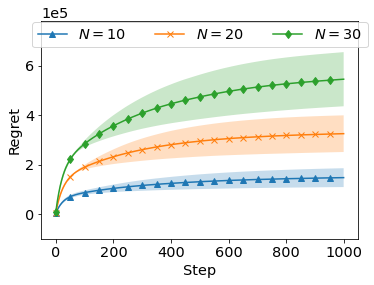

In [282]:
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams['font.size'] = 14.5

eta = 0.002
delta = 0.1

ls = []

markers = ['^', 'x', 'd']

Nds = [(10, 5), (20,5), (30,5)]

for i in range(len(markers)):
    
    (N,d) = Nds[i]
    
    res = pickle.load( open( 'resN{0}d{1}eta{2}delta{3}'.format(N,d,eta,delta) , 'rb' ) ) 
    
    reg = np.array(res[0]) - res[1]
    
    reg = np.cumsum( reg, axis = 1 )
    
    reg_m = np.mean( reg , axis = 0 ) 
    reg_std = np.std( reg , axis = 0 ) 
    
    l, = plt.plot(reg_m, label = '$N = {0}$'.format(N), marker = markers[i], markevery = 50 )
    
    ls.append(l)
#     labels.append() 

    plt.fill_between(range(len(reg_m)), reg_m - reg_std, reg_m + reg_std, alpha = 0.25 )
    
plt.xlabel('Step')

plt.ylabel('Regret') 

plt.legend( handles = ls, loc = 'upper center', bbox_to_anchor=(0.5, 1.03),
          ncol=3, fancybox=True ) 

plt.ylim(-100000, 7.8e5)

plt.tight_layout() 

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('d5eta0.002mu0.1.png', dpi = 150) 

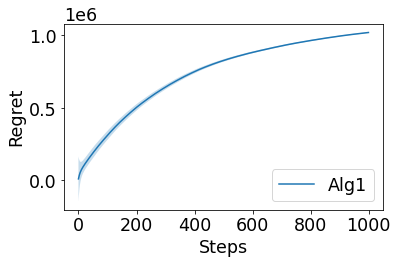

In [218]:
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams['font.size'] = 17.5


regret = np.cumsum( np.maximum( ds_m, 0 ) )

l_s, = plt.plot(regret, label = 'Alg1') 
# l, = plt.plot(ds_unstabilized, label = 'Alg1') 

plt.fill_between(range(len(ds_m)), regret - 10 * regret_std, regret + 10 * regret_std, alpha = 0.25 )

# plt.xlim(-10,150)

plt.xlabel('Step')

plt.ylabel('Regret') 

plt.legend( handles = [l_s], loc = 'lower right' ) 

plt.tight_layout() 

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('N20d10eta0.002mu0.1.png', dpi = 150) 

# plot grad. est. versus grad. truth

In [134]:
tmp = np.random.uniform(-1, 1, size = 3 )

In [298]:
eta = 0.0001; 
delta = 0.01

point = np.array([ np.random.uniform( 50, 150 ) , np.random.uniform( 150, 250 ) ] )

pts = []

ds_stablized = [] 

N = 10 

Ws = [ 
    np.array([[1,0], [0,0]]), np.array([[0,1], [0,0]]), np.array([[0,0], [1,0]]), np.array([[0,0], [0,1]]),
    np.array([[-1,0], [0,0]]), np.array([[0,-1], [0,0]]), np.array([[0,0], [-1,0]]), np.array([[0,0], [0,-1]])
] 

gs_ = []
gs_true = []

errors = []

N = 1

for _ in range(50):
    
    X = np.random.uniform(-10, 10, size = (2,2) )  

#     X = np.dot(X, X.T) + np.identity(2)
    X = np.identity(2)

    Xp = np.real( fractional_matrix_power(X, 1./2) )
    
    while True:

        W = np.random.uniform(-1, 1, size = (2,2) ) # approximate a "ball", 
        
        W = (W + W.T) / 2

        l = np.linalg.norm( W )

        if (l > 0.99) & (l<1.01): 
            break
            
    g_ = np.zeros((2,2)) 
        
    for j in range(N): 

        new_X1 = np.dot( np.dot( Xp, expm( delta * W ) ), Xp ) 
        new_X2 = np.dot( np.dot( Xp, expm( -delta * W ) ), Xp ) 

        g_ = g_ + ( func(new_X1) * W - func(new_X2) * W )/2. * 3 / delta 
        
    g_ = g_ / N 
            
    g_true = true_grad(X) 
    
    gs_.append(g_) 
    
    gs_true.append(g_true) 
    
#     errors = 

In [310]:
( func( new_X1 ) - func( new_X2 ) ) * W 

array([[ 0.02128482, -0.03426476],
       [-0.03426476, -0.01249334]])

In [304]:
g_ = ( func( new_X1 ) - func( new_X2 ) ) * W 

g_true = true_grad( X ) 

In [307]:
g_

array([[ 0.02128482, -0.03426476],
       [-0.03426476, -0.01249334]])

In [308]:
g_true 

array([[-0.41993671, -0.59224903],
       [-0.59224903, -1.48646489]])

In [309]:
np.arccos( np.sum( g_ * g_true ) / np.linalg.norm( g_ ) / np.linalg.norm( g_true ) )


1.0174203155683428

In [300]:
func(X) 

28.096479601744086

In [301]:
gs_[0] 

array([[ 0.7364504 ,  1.65604621],
       [ 1.65604621, -4.06935911]])

In [302]:
while True:

    W = np.random.uniform(-1, 1, size = (2,2) ) # approximate a "ball", 

    W = (W + W.T) / 2

    l = np.linalg.norm( W )

    if (l > 0.99) & (l<1.01): 
        break

In [303]:
np.arccos( np.sum( gs_[0] * gs_true[0] ) / np.linalg.norm( gs_[0] ) / np.linalg.norm( gs_true[0] ) )
# , gs_true[0]) 

1.1013142630785668

In [263]:
( func(new_X1) - func(new_X2) ) * W / 2. * 3 / delta

array([[-6.5769044 , -2.10327812],
       [-2.10327812, -3.68938981]])

In [265]:
gs_true 

[array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.59224903, -1.48646489]]), array([[-0.41993671, -0.59224903],
        [-0.592

In [272]:
gs_

[array([[ 1.53063749, -3.5065624 ],
        [-3.5065624 , -0.69215823]]), array([[-5.11948029, -0.4552135 ],
        [-0.4552135 , -1.34726625]]), array([[-0.28363121, -3.33813008],
        [-3.33813008, -8.97575405]]), array([[-0.60246166,  0.01491874],
        [ 0.01491874,  0.11634518]]), array([[-3.94263427, -1.47658133],
        [-1.47658133,  0.09416076]]), array([[ 2.07367071,  1.12928391],
        [ 1.12928391, -4.13945877]]), array([[-6.1775715 , -0.76303338],
        [-0.76303338, -5.53937882]]), array([[ 3.45783441, -0.18351638],
        [-0.18351638, -5.29626769]]), array([[ 1.07471506,  0.47204287],
        [ 0.47204287, -7.86820586]]), array([[ 2.30528066,  0.74988262],
        [ 0.74988262, -3.00787373]]), array([[-0.67553717, -3.25166432],
        [-3.25166432, -9.17890921]]), array([[ 0.92996267,  1.14083614],
        [ 1.14083614, -7.07829536]]), array([[ 3.61289009, -0.56452117],
        [-0.56452117, -3.40314812]]), array([[-6.0264363 , -1.85312889],
        [-1.853

In [247]:
func(new_X1) 

28.070042652681856

In [266]:
errors = []

for i in range(len(gs_true)): 
    
    errors.append( np.linalg.norm( gs_true[i] - gs_[i] ) / np.linalg.norm( gs_true[i] ) )

In [267]:
gs_true[i]

array([[-0.41993671, -0.59224903],
       [-0.59224903, -1.48646489]])

In [268]:
gs_[i]

array([[-6.5769044 , -2.10327812],
       [-2.10327812, -3.68938981]])

In [269]:
gs_[i] 

array([[-6.5769044 , -2.10327812],
       [-2.10327812, -3.68938981]])

In [270]:
np.mean( errors ) 

2.8554937868685584

In [271]:
errors  

[2.634096352254698,
 2.678029114000062,
 4.801790559513179,
 1.0400378429226163,
 2.3097869171848857,
 2.492688118334551,
 4.009532300323075,
 3.1112379514000486,
 3.827320422181901,
 2.0789578312176533,
 4.875299278967246,
 3.5585873868526625,
 2.541272305734529,
 3.3803317914158,
 1.7396517066584585,
 1.5078990349335384,
 1.0431638787759625,
 1.4762762284486648,
 2.0230375413308543,
 3.442315671736321,
 3.329793804576603,
 4.874936248507798,
 3.3654673261740933,
 4.608030976344748,
 1.1389262560519016,
 3.313334947619937,
 4.193784036689573,
 1.2616967646784187,
 4.4068877701128395,
 3.0761287224662,
 2.225377491213849,
 4.090978954254043,
 1.034923587072861,
 2.081104983599919,
 1.995682250601765,
 2.1784834837914424,
 2.1507235694921847,
 4.009175352491278,
 1.0385171195075906,
 2.3763436654576426,
 2.478795955037941,
 2.607899273567296,
 4.497788692229892,
 1.0894609309588112,
 1.6490198299503502,
 3.639570261715176,
 4.008020365617906,
 4.273523013097569,
 3.293768971497229,
 3.9

In [16]:
gradient func(Xp) 

46.05121549961096

In [17]:
Xp

array([[37.92922445, 13.54328155],
       [13.68238322, 33.53464965]])

In [13]:
np.dot( np.dot( Xp, expm( delta * W ) ), Xp )

array([[1507.24259507,  858.95446765],
       [ 888.42618417, 1198.81009301]])

In [679]:
ds_min = np.min(ds_stablized)

In [680]:
X = np.random.uniform(15, 15, size = (2,2) )  

X = np.dot(X, X.T) 

In [681]:
np.linalg.norm(X)

900.0

In [725]:
eta = 0.0001; 
delta = 0.1

point = np.array([ np.random.uniform( 50, 150 ) , np.random.uniform( 150, 250 ) ] )

pts = []

ds_stablized = [] 

N = 10 

Ws = [ 
    np.array([[1,0], [0,0]]), np.array([[0,1], [0,0]]), np.array([[0,0], [1,0]]), np.array([[0,0], [0,1]]),
    np.array([[-1,0], [0,0]]), np.array([[0,-1], [0,0]]), np.array([[0,0], [-1,0]]), np.array([[0,0], [0,-1]])
] 

for _ in range(5):
    
    X = np.random.uniform(10, 50, size = (2,2) )  

    X = np.dot(X, X.T) 
    
    ds_stablized_inner = []

    for i in range(500): 

        g_ = np.zeros((2,2)) 

        Xp = np.real( fractional_matrix_power(X, 1./2) )

    #     for W in Ws:
        while True:

            W = np.random.uniform(-1, 1, size = (2,2) ) # approximate a "ball", 

            l = np.linalg.norm( W )

            if (l > 0.98) & (l<1.02): 
                break

        new_X1 = np.dot( np.dot( Xp, expm( delta * W ) ), Xp )
        new_X2 = np.dot( np.dot( Xp, expm( -delta * W ) ), Xp )

        d1 = func(new_X1) 
        d2 = func(new_X2) 

        g_ = ( func(new_X1) * W - func(new_X2) * W )/2. * 4 / delta

        Xp = np.real( fractional_matrix_power(X, 1./2) )

        X = np.real( np.dot( np.dot( Xp, expm( - eta * g_ ) ), Xp ) )

        pts.append( np.real( X ) ) 
        
        ds_stablized_inner.append( func( np.real( X ) ) )
    
    ds_stablized.append( ds_stablized_inner )  

In [731]:
eta = 0.0001; 
delta = 0.1 

point = np.array([ np.random.uniform( 50, 150 ) , np.random.uniform( 150, 250 ) ] )

pts = []

ds_unstablized = [] 

# X = np.random.uniform(5, 15, size = (2,2) )  

# X = np.dot(X, X.T) 

print(X) 

for _ in range(5):
    
    X = np.random.uniform(5, 15, size = (2,2) )  

    X = np.dot(X, X.T) 
    
    ds_unstablized_inner = []

    for i in range(500): 

        g_ = np.zeros((2,2)) 

        Xp = np.real( fractional_matrix_power(X, 1./2) )

        while True:

            W = np.random.uniform(-1, 1, size = (2,2) ) # approximate a "ball", 

            l = np.linalg.norm( W )

            if (l > 0.98) & (l<1.02): 
                break

        new_X1 = np.dot( np.dot( Xp, expm( delta * W ) ), Xp )
    #     new_X2 = np.dot( np.dot( Xp, expm( -delta * W ) ), Xp )

        d1 = func(new_X1) 
    #     d2 = func(new_X2) 

        g_ = func(new_X1) * W * 4 / delta

        print('X', X )
        print('|g_|', np.linalg.norm(g_) ) 

        Xp = np.real( fractional_matrix_power(X, 1./2) )

        X = np.real( np.dot( np.dot( Xp, expm( - eta * g_ ) ), Xp ) )

        X = X/np.linalg.norm(X) * 900

        pts.append( np.real( X ) ) 
        
        ds_unstablized_inner.append( func( np.real( X ) ) )

    ds_unstablized.append( ds_unstablized_inner )  

[[-241.04476075   27.9859402 ]
 [-861.2206264    97.02186937]]
X [[196.48318847 162.6836721 ]
 [162.6836721  136.31986976]]
|g_| 2677.7849036357934
X [[535.59906324 439.60308839]
 [441.06784593 367.88846602]]
|g_| 3042.4785653265585
X [[529.19352784 432.09150098]
 [449.94198391 375.23773264]]
|g_| 2973.5954477808095
X [[525.43604014 426.94494302]
 [456.29239138 378.72448683]]
|g_| 3078.965624773312
X [[526.21415583 425.14922425]
 [455.9636445  380.05783011]]
|g_| 2929.5393003255845
X [[533.98539009 420.27919641]
 [458.23049591 371.81959719]]
|g_| 3033.723803859111
X [[541.7922789  408.70045777]
 [466.23191373 363.39078822]]
|g_| 3067.80793329473
X [[551.36375237 421.33052979]
 [449.73534069 355.26992636]]
|g_| 3022.269737628624
X [[559.46730153 431.58887805]
 [435.46734358 347.98788993]]
|g_| 2933.8495808902526
X [[560.05642453 448.12309758]
 [418.40001194 347.07912754]]
|g_| 2984.6496893056124
X [[564.21665796 450.51943723]
 [414.69724241 341.64015675]]
|g_| 2967.638812192211
X [[576.

X [[600.02448421 399.56192607]
 [442.76482067 307.05080877]]
|g_| 2939.893172769203
X [[595.71243623 400.55003612]
 [446.10244058 309.32018105]]
|g_| 3030.8644199469272
X [[593.01138794 390.37362699]
 [457.60743747 310.71105275]]
|g_| 2990.5259229435774
X [[592.89178187 384.11452212]
 [464.79034521 308.06704446]]
|g_| 2981.973937145539
X [[584.23802003 385.21820714]
 [470.0218478  315.20204857]]
|g_| 2992.7153114195467
X [[592.87210896 389.8662092 ]
 [460.08260629 307.9464186 ]]
|g_| 2962.245915175444
X [[592.0384185  384.6929894 ]
 [465.84460623 307.39326239]]
|g_| 3054.995078494776
X [[600.93584192 386.04632236]
 [458.03180647 300.08534645]]
|g_| 2945.1998738553348
X [[604.95183449 386.14409699]
 [455.95764654 295.0061675 ]]
|g_| 2998.2569921396407
X [[602.77550174 377.88962776]
 [465.14679628 295.80328201]]
|g_| 3101.311028289139
X [[604.29119148 383.31543179]
 [458.31883973 296.38703886]]
|g_| 3003.176164045043
X [[593.54369945 383.51946232]
 [465.05655142 307.14996801]]
|g_| 2957.

X [[529.6524532  440.1049903 ]
 [443.11250076 373.39950188]]
|g_| 3009.73328760223
X [[523.36221611 450.19113597]
 [434.85253109 379.89894452]]
|g_| 3003.37036823437
X [[519.74676873 454.1124453 ]
 [431.79561972 383.66355862]]
|g_| 2992.488099456327
X [[516.20018195 466.61336254]
 [419.93622564 386.60433061]]
|g_| 3031.218107115768
X [[510.25558459 462.3397904 ]
 [426.31680259 392.6004845 ]]
|g_| 3025.5729500247803
X [[511.63383801 471.17313464]
 [417.23946238 390.04861752]]
|g_| 3054.9859348443333
X [[513.02192827 475.74069929]
 [411.18530884 389.10914914]]
|g_| 3026.629242727341
X [[516.27371849 465.01543443]
 [421.22432964 387.02991805]]
|g_| 3073.5035220802774
X [[520.43192446 475.21057087]
 [408.14443632 383.07133074]]
|g_| 3031.031165304585
X [[525.90053004 486.27436377]
 [392.92944859 377.5875052 ]]
|g_| 2978.721912358094
X [[520.84586692 500.42918703]
 [379.21108265 380.1173062 ]]
|g_| 3047.1418627168837
X [[525.27845483 484.89487185]
 [391.72988812 381.45406395]]
|g_| 2992.902

X [[564.05377229 491.91522719]
 [373.41579748 332.30015559]]
|g_| 3007.4603303876033
X [[570.22575077 496.84156781]
 [365.06086673 323.60718971]]
|g_| 2953.191831422502
X [[570.82982546 505.67972523]
 [354.88913073 320.1484511 ]]
|g_| 3096.636962799463
X [[567.69013219 501.08437093]
 [360.74562994 326.35097289]]
|g_| 3082.198236200907
X [[567.2246959  493.67430715]
 [367.77420203 330.5812444 ]]
|g_| 2978.3593784577292
X [[569.9396331  491.18530346]
 [370.66535    326.36331073]]
|g_| 3071.993603355766
X [[570.3583279  486.25985707]
 [374.07201644 329.1091851 ]]
|g_| 2960.432962878827
X [[573.0622232  483.70797599]
 [375.21652797 326.86211076]]
|g_| 3012.0952898116893
X [[579.29528212 489.41871906]
 [362.77418963 321.37389579]]
|g_| 3050.859715460458
X [[576.20455695 482.85321956]
 [368.4211279  330.3134109 ]]
|g_| 2996.0268855159884
X [[576.66308036 495.73920915]
 [356.04472765 323.93591985]]
|g_| 3058.0685423238306
X [[571.05112994 494.92937532]
 [363.44089147 326.88872548]]
|g_| 2995.

X [[560.8581098  534.96116491]
 [325.16337902 321.75069486]]
|g_| 3083.8176332967973
X [[562.310209   521.73498163]
 [337.80300419 327.85510239]]
|g_| 3106.902338258957
X [[565.46895576 515.37369761]
 [344.25372533 325.76707088]]
|g_| 3003.7226730956854
X [[560.83745011 533.26970615]
 [325.63302259 324.1109527 ]]
|g_| 3047.1281625037377
X [[564.09080916 543.11518615]
 [312.59884224 314.81648213]]
|g_| 3102.2562117596613
X [[551.43467713 555.8397987 ]
 [304.94661084 322.44298656]]
|g_| 3151.571032898969
X [[565.66276113 539.84720573]
 [313.74558268 316.47171198]]
|g_| 3103.953283959648
X [[567.34706361 537.20851828]
 [314.74550249 316.95360222]]
|g_| 3077.5867883548917
X [[565.12190281 551.45115386]
 [298.11790543 312.51331865]]
|g_| 3128.121934106991
X [[580.91941823 530.24734065]
 [313.11188622 305.50177406]]
|g_| 3073.478893767515
X [[583.87040218 515.103129  ]
 [331.28894941 306.61335905]]
|g_| 3084.252835259943
X [[578.06778901 528.21030183]
 [317.50686432 309.87239222]]
|g_| 3038.

X [[501.21999312 630.42677663]
 [247.53596796 316.33296126]]
|g_| 3378.546062780608
X [[502.40118369 640.19993673]
 [233.95566005 304.96203169]]
|g_| 3321.6489505583013
X [[497.46014805 639.35935669]
 [236.20937802 312.98265742]]
|g_| 3308.243963992798
X [[487.33728046 640.32581368]
 [238.38700765 325.04901476]]
|g_| 3287.0348682699573
X [[479.56719142 637.0900297 ]
 [246.22353306 336.9058841 ]]
|g_| 3337.073262865368
X [[232.91936489 153.28991081]
 [153.28991081 104.41087226]]
|g_| 2550.2934413996786
X [[628.37616188 413.14970021]
 [409.8292457  276.569546  ]]
|g_| 3011.95051024694
X [[627.66521509 399.48289837]
 [423.23257408 278.07189702]]
|g_| 2970.021567360587
X [[619.81875085 403.48543658]
 [425.72304951 285.97920147]]
|g_| 2991.9755138717924
X [[620.04885161 395.67165362]
 [431.09048872 288.34762817]]
|g_| 2976.6069981434543
X [[607.62761504 393.59701762]
 [443.6687357  298.37580687]]
|g_| 3006.516759913496
X [[605.12289392 399.15922427]
 [440.72538813 300.43190441]]
|g_| 3020.2

X [[576.71758453 274.39911848]
 [565.99183704 285.92864821]]
|g_| 3139.356567559543
X [[562.45772027 260.02446708]
 [585.71612348 288.03682424]]
|g_| 3078.0182598943343
X [[569.86609545 254.34335594]
 [586.50557171 276.7188192 ]]
|g_| 3206.71135531526
X [[554.32390723 242.93625306]
 [604.11365397 280.63085345]]
|g_| 3255.742012912062
X [[540.03472258 224.29884031]
 [622.03571561 284.82292245]]
|g_| 3278.186695278506
X [[549.38625296 229.50565785]
 [614.0012107  280.18638678]]
|g_| 3232.8997885817666
X [[562.6953366  243.18747974]
 [597.95967798 276.9079836 ]]
|g_| 3214.038677015634
X [[550.79261285 231.5792697 ]
 [609.98322119 284.46266775]]
|g_| 3226.2507051288103
X [[541.73416943 257.60509802]
 [596.87209365 306.44315455]]
|g_| 3175.1824605723136
X [[537.46054253 228.24360805]
 [616.28813635 298.7138323 ]]
|g_| 3279.6492555227987
X [[511.91659415 185.48049002]
 [652.86414481 295.4772358 ]]
|g_| 3301.5855699401786
X [[544.05632351 212.29936099]
 [617.98935197 294.99298131]]
|g_| 3297.

X [[605.79530066 395.56738309]
 [441.28468616 302.9955856 ]]
|g_| 3059.283633567518
X [[598.89158094 396.34143584]
 [445.78532447 309.05951692]]
|g_| 3033.9611980944023
X [[584.46653713 386.55140628]
 [464.07163866 321.89189408]]
|g_| 3003.923847392605
X [[600.22256716 373.0243471 ]
 [465.19208149 306.89091493]]
|g_| 3005.3967897829302
X [[620.22142436 362.87672377]
 [458.40548764 288.98144753]]
|g_| 3065.6305388251485
X [[640.40260779 345.74360657]
 [455.98592451 269.11465048]]
|g_| 3007.612037466602
X [[636.29224248 364.7789412 ]
 [444.34764642 273.17334303]]
|g_| 3020.6122842089526
X [[633.89526457 380.15870608]
 [429.35375157 281.6229887 ]]
|g_| 3064.4396686357204
X [[623.74586121 403.12628913]
 [412.15602296 297.58647208]]
|g_| 3037.724841465987
X [[629.53110739 417.4384208 ]
 [392.14299988 292.67664293]]
|g_| 3010.1248439810383
X [[638.57286866 433.32015054]
 [369.38198287 279.31217173]]
|g_| 2981.897155220986
X [[642.98587553 430.25044005]
 [373.06164125 268.84704673]]
|g_| 3070

X [[539.58964485 544.31301309]
 [322.87718301 343.97192277]]
|g_| 3045.7175546865433
X [[546.971195   523.62232529]
 [342.02584652 345.91977771]]
|g_| 3092.96092869784
X [[563.59899419 507.17083764]
 [349.20667411 336.43515565]]
|g_| 2999.931023309879
X [[564.05482537 524.88902178]
 [325.82575547 331.92054149]]
|g_| 3042.7816119956246
X [[550.32462831 510.88819568]
 [348.87351043 352.73691147]]
|g_| 3060.2396593502276
X [[574.63360539 496.77627251]
 [352.05392975 330.25381932]]
|g_| 3116.545637830254
X [[552.05167689 494.81086611]
 [367.64629119 353.88890545]]
|g_| 3043.0425032240646
X [[554.63667918 502.95457106]
 [361.20040519 344.89001268]]
|g_| 3063.395307959299
X [[548.98421731 500.65259484]
 [365.96287797 352.18529266]]
|g_| 3013.15432178613
X [[540.17122043 490.86368743]
 [382.31398081 362.08274339]]
|g_| 3060.487298876102
X [[556.26792307 482.81436783]
 [383.53194567 346.92871116]]
|g_| 3089.123234545146
X [[570.91389722 480.3129542 ]
 [378.88885782 331.36086281]]
|g_| 2998.276

X [[572.63523644 491.77007911]
 [363.33405218 328.99763191]]
|g_| 2955.3969599097422
X [[567.04398064 494.76677157]
 [366.09384398 331.12273128]]
|g_| 2994.0406556312237
X [[581.55622454 490.09709743]
 [360.59567516 318.69727305]]
|g_| 3084.5826945889453
X [[567.1512372  509.092905  ]
 [346.7324474  330.06135512]]
|g_| 2992.314639952749
X [[559.96084026 517.09227136]
 [339.31301184 337.52943615]]
|g_| 3131.94023167722
X [[580.32056519 501.74728174]
 [340.91801922 324.42658807]]
|g_| 3117.127897411062
X [[578.64293712 504.86940368]
 [330.67656171 333.06493073]]
|g_| 3053.9095867938267
X [[568.316434   486.89502878]
 [357.90261197 349.07790268]]
|g_| 3104.5279534790793
X [[569.24059274 478.23872805]
 [358.47540085 358.81506874]]
|g_| 3088.6294621667034
X [[599.81810476 449.1552351 ]
 [364.65038767 339.86454765]]
|g_| 3069.742550908078
X [[607.33851259 465.34926085]
 [351.06681859 318.34271695]]
|g_| 3056.9882646431406
X [[616.28331809 483.48091061]
 [328.55592929 297.47618769]]
|g_| 3055

X [[642.51784719 488.1691232 ]
 [226.23444005 328.14585375]]
|g_| 3351.6360425250896
X [[684.14603422 489.7100701 ]
 [133.06247433 290.55572447]]
|g_| 3309.7261521930855
X [[667.0266211  538.24813633]
 [ 89.08293147 259.67029441]]
|g_| 3385.4924275951053
X [[651.80956715 510.35535181]
 [163.5134191  312.96176257]]
|g_| 3392.4313888602915
X [[667.7183739  435.64363319]
 [248.56136678 335.53546005]]
|g_| 3287.4055096366437
X [[237.51527528 144.36890718]
 [144.36890718 132.38162862]]
|g_| 2772.125641517641
X [[596.79547826 415.98913184]
 [352.42465904 395.70830042]]
|g_| 3333.8592321087303
X [[602.29117481 426.98034235]
 [332.39567705 392.99649092]]
|g_| 3227.4972239040053
X [[637.33990566 439.110276  ]
 [317.8733897  331.56676294]]
|g_| 3133.1185878733595
X [[637.11589289 436.56567956]
 [311.52499655 341.24173688]]
|g_| 3270.1275203280697
X [[621.68958626 422.46824548]
 [358.17423063 341.66337294]]
|g_| 3189.3462903901054
X [[617.7981028  382.75884704]
 [389.4241173  360.79083423]]
|g_| 

X [[519.98298794  88.21779877]
 [469.42601171 558.09903401]]
|g_| 3384.256662025115
X [[573.58285977 -53.29934396]
 [510.27758464 466.66762211]]
|g_| 3506.5139674901325
X [[551.88137265 -30.04092886]
 [604.49866236 372.96898037]]
|g_| 3450.396606553004
X [[ 561.4924391  -132.6861607 ]
 [ 536.12219915  435.53830047]]
|g_| 3569.8027041010855
X [[441.10949357 -65.50637259]
 [569.14595403 535.91437081]]
|g_| 3576.866643485099
X [[452.74870513  72.15647557]
 [525.64647114 568.7774964 ]]
|g_| 3456.710532199551
X [[481.50895947 184.08226481]
 [464.24096296 573.36129102]]
|g_| 3450.659755749718
X [[506.80713274 207.25320591]
 [387.5362251  600.00692752]]
|g_| 3338.1466624489244
X [[494.76025492  54.95250611]
 [459.35291377 592.6106756 ]]
|g_| 3493.6983372540117
X [[449.94375968 106.62154548]
 [531.74694204 559.84609384]]
|g_| 3395.3222632697552
X [[502.88917498 -16.07412948]
 [563.97901677 488.6427823 ]]
|g_| 3472.4932429766723
X [[377.56547455   7.66327353]
 [583.81611084 571.44057905]]
|g_| 

X [[603.19596307 337.76668537]
 [478.58254435 320.97826193]]
|g_| 3134.4557326201148
X [[589.32726526 372.20403418]
 [461.01778686 334.09599154]]
|g_| 3083.5750105161414
X [[594.4376414  403.73955939]
 [430.03782421 329.70551772]]
|g_| 3080.524958009686
X [[606.4507099  409.6914937 ]
 [421.32601361 311.21504898]]
|g_| 2993.69580556513
X [[600.32210776 421.16418752]
 [416.37031282 314.43577513]]
|g_| 2949.8628906884433
X [[592.12963513 429.67118339]
 [416.80885898 317.8608885 ]]
|g_| 3014.85359669981
X [[599.0990633  413.44744177]
 [426.05312922 314.03862236]]
|g_| 2963.8376137087853
X [[599.76835018 425.25263196]
 [413.30727067 314.03061178]]
|g_| 3000.810945665435
X [[580.23788135 441.93649351]
 [407.88882265 334.12998235]]
|g_| 3033.828612431105
X [[580.19305179 455.63641354]
 [391.87028509 334.97635884]]
|g_| 3125.3263991731865
X [[576.86776073 446.44821385]
 [404.34947622 338.24411312]]
|g_| 3102.270882667047
X [[589.98811569 458.36275424]
 [382.80969885 324.46007973]]
|g_| 3055.99

X [[633.86660335 345.62847034]
 [471.37684929 257.9882858 ]]
|g_| 3146.656387199341
X [[633.81683473 348.66044548]
 [468.85381069 258.62756615]]
|g_| 3182.981651246713
X [[634.27485435 345.29842331]
 [471.38211052 257.41661539]]
|g_| 3142.2833062263358
X [[638.77375478 344.44489333]
 [468.15582543 253.29020664]]
|g_| 3163.9640036006585
X [[643.00158574 343.2613794 ]
 [465.33377752 249.36932779]]
|g_| 3172.3951928349766
X [[638.30371312 343.06335373]
 [469.69385063 253.50264658]]
|g_| 3067.551508952118
X [[642.7061573  338.28699647]
 [469.86563784 248.42903568]]
|g_| 3122.5890359419723
X [[645.7803642  341.73843887]
 [464.07540796 246.6101708 ]]
|g_| 3087.3168689178938
X [[644.08929317 341.68574812]
 [465.48022286 248.45119053]]
|g_| 3056.0956792067454
X [[647.6007385  341.93644903]
 [462.17215574 245.1318967 ]]
|g_| 3091.9912322545283
X [[652.10631745 343.3572822 ]
 [456.65847384 241.50810704]]
|g_| 3137.511285935528
X [[655.56988818 339.91022099]
 [456.27902253 237.69437726]]
|g_| 308

X [[631.50216643 305.4102117 ]
 [506.51426715 247.73557185]]
|g_| 3065.191773802439
X [[625.08144379 308.80009906]
 [508.82482301 254.97644389]]
|g_| 3170.8273767482024
X [[629.56324473 306.17336309]
 [506.94445426 250.8292505 ]]
|g_| 3075.948029783911
X [[630.2953697  316.51334193]
 [497.66304742 254.71266665]]
|g_| 3012.2987171583195
X [[637.41259412 304.33562155]
 [500.96065642 245.20080553]]
|g_| 3077.8672421153196
X [[626.02775712 299.36953553]
 [514.39594158 252.71316509]]
|g_| 3057.695476254939
X [[626.87644655 291.90738981]
 [520.1071615  247.59753048]]
|g_| 3049.8770600302087
X [[630.40721254 295.52681057]
 [515.0265831  244.9454415 ]]
|g_| 3080.437570703413
X [[627.89217225 298.26282292]
 [514.808257   248.52196485]]
|g_| 3104.131813513593
X [[623.61736612 301.44041243]
 [515.89617367 253.15251613]]
|g_| 3092.623202668894
X [[622.9797967  297.41244476]
 [518.76638141 253.62068552]]
|g_| 3016.0765218148053
X [[616.4951771  304.79966719]
 [518.43943807 261.24970534]]
|g_| 3110.

X [[576.28988013 341.65929428]
 [515.16279322 309.46114001]]
|g_| 3106.089105279976
X [[569.77570394 334.65634502]
 [525.08746533 312.48029009]]
|g_| 3097.620390738064
X [[569.11279349 340.88868092]
 [519.96486492 315.50289183]]
|g_| 3065.596975379296
X [[572.38849491 344.59782743]
 [515.41886402 312.99703327]]
|g_| 3125.3587302535916
X [[573.13214204 347.80400855]
 [512.40965895 313.03076656]]
|g_| 3092.5914259713427
X [[573.46984134 340.4039897 ]
 [518.76860774 310.05902097]]
|g_| 3141.5461639167693
X [[289.01185025 313.00007873]
 [313.00007873 357.39436714]]
|g_| 2865.1114288761337
X [[424.47362326 445.54884676]
 [439.96748229 487.58279588]]
|g_| 2995.436119977026
X [[416.19046406 439.97212801]
 [439.68308502 499.88879658]]
|g_| 3084.256591371896
X [[428.45039672 463.28058843]
 [417.29597603 487.50940742]]
|g_| 3075.443239643462
X [[428.23837531 458.80473996]
 [413.00439882 495.51737715]]
|g_| 2997.2368524194853
X [[405.78252856 448.79387374]
 [421.31426579 516.15781293]]
|g_| 3063.

X [[302.19002943 508.56032969]
 [335.34559507 589.56840914]]
|g_| 3051.5406219155766
X [[306.58191562 509.47770712]
 [340.99709279 583.23321036]]
|g_| 3014.450366051423
X [[300.29848444 501.78834411]
 [344.92313712 590.81072049]]
|g_| 2976.3189483026067
X [[301.6134694  515.4857139 ]
 [333.5543141  584.84640154]]
|g_| 3056.042065274574
X [[306.69581217 524.98206654]
 [328.90463172 576.32738252]]
|g_| 3119.5477326702876
X [[302.86221006 520.17144879]
 [330.54085921 581.75500511]]
|g_| 3073.9154542821657
X [[306.1849981  519.69495621]
 [330.98275    580.1881752 ]]
|g_| 3047.3322060404685
X [[302.82854283 529.94976304]
 [319.53100996 579.09244165]]
|g_| 3033.947368315907
X [[301.02279338 514.35075901]
 [331.57715487 587.26924399]]
|g_| 3062.723644533553
X [[295.66812856 520.03376563]
 [320.35351317 591.20120683]]
|g_| 3118.179206073492
X [[310.03606349 519.56166697]
 [325.82901438 581.17877365]]
|g_| 3017.275340839432
X [[316.77448109 533.59111326]
 [319.31914985 568.30426052]]
|g_| 3049.

X [[265.36210649 791.6068007 ]
 [ 37.74774269 333.94121256]]
|g_| 3776.527691129024
X [[192.60167499 795.57412124]
 [ 20.39160641 373.56471299]]
|g_| 3786.4859613632984
X [[193.45001104 786.36666388]
 [ 50.76740727 389.39341742]]
|g_| 4011.0440256333045
X [[243.21081367 770.52547855]
 [ 94.69810263 384.93019676]]
|g_| 3781.8955328114494
X [[241.05862912 791.21779819]
 [ 70.17659406 347.7648326 ]]
|g_| 3788.6626561005905
X [[246.43723066 811.63169117]
 [ 40.66987914 298.1084537 ]]
|g_| 3911.7753582970827
X [[219.64857734 796.86077841]
 [ 63.1039984  350.40731683]]
|g_| 3829.246187264383
X [[152.09094628 818.98724089]
 [ 12.94728443 340.52989758]]
|g_| 3892.022841071372
X [[ 55.35776216 852.13706506]
 [-74.17431346 274.40136978]]
|g_| 4323.974280878625
X [[104.62722943 864.19615966]
 [-58.4938844  220.89953819]]
|g_| 4443.321628414715
X [[143.26262525 878.81932185]
 [-77.24430173 105.76264747]]
|g_| 5518.308527921697
X [[ 113.53046362  885.29353774]
 [-115.5702126     3.11638042]]
|g_| 5

ValueError: array must not contain infs or NaNs

In [727]:
ds_stablized

[[97.50815639150574,
  97.50382993979042,
  97.49084982392714,
  97.48730660785287,
  97.48683569387183,
  97.47235232987364,
  97.4409979279453,
  97.43689916435129,
  97.42303115688436,
  97.42034254268903,
  97.41527435519674,
  97.39765073368984,
  97.39764887751247,
  97.39420750331297,
  97.3686353230234,
  97.35046735021405,
  97.34152579137347,
  97.31132017563772,
  97.30927628341534,
  97.29952398150236,
  97.29382631294027,
  97.28298700222345,
  97.27620950758742,
  97.27171769706753,
  97.270423602742,
  97.25557262038242,
  97.23223330433697,
  97.22998602609668,
  97.20012201896219,
  97.18637712955389,
  97.18225796241431,
  97.18092229394713,
  97.17980360253085,
  97.16038711698897,
  97.16019796706595,
  97.15937140729544,
  97.15473970863727,
  97.14625916943524,
  97.14625885950015,
  97.14606386250347,
  97.1429645093671,
  97.12228200190944,
  97.08880723480753,
  97.06848115630581,
  97.04228844198634,
  97.03916212871685,
  97.03827036692081,
  97.0348615905159

In [728]:
plt.plotds_unstablized

[[77.78433515761436,
  77.16146946117487,
  76.40081217718124,
  76.00048575983841,
  75.61429518649128,
  75.67599964705937,
  75.90198159310759,
  75.51509138988871,
  75.18658111173828,
  75.46602415748768,
  75.21458926847589,
  75.11530723019054,
  75.04278209041648,
  75.09918936252713,
  75.55710196391483,
  75.4921221965845,
  75.94889515785573,
  76.49527750879085,
  76.14096811200137,
  75.93647990371572,
  75.5597046038839,
  75.70954367588978,
  75.37489316013017,
  75.5795083330784,
  75.23375185968656,
  75.26334812294374,
  75.56799959609002,
  75.80928920869435,
  76.34684942216768,
  76.1976751783665,
  75.91475632035477,
  75.44880016547705,
  75.64220778320272,
  75.1874479753863,
  75.05911855830675,
  75.2151875127628,
  75.49174649271454,
  75.18990780175838,
  75.65795681970314,
  75.5530873681476,
  75.80696656395645,
  76.09717336634574,
  76.14541705482014,
  76.5784372930122,
  77.33961428870019,
  77.21605821176264,
  76.41384244852628,
  76.1154239539927,
 

In [729]:
ds_stablized = np.array(ds_stablized) - ds_min
ds_unstablized = np.array(ds_unstablized) - ds_min

In [732]:
ds_unstablized

[[74.99943983640928,
  74.93105739066023,
  74.9556374664262,
  75.00936050131286,
  75.00903250379353,
  75.09093283159048,
  74.99555280868235,
  74.98403113547127,
  75.0247899327513,
  74.96311837694198,
  74.95313127124882,
  74.90950532208414,
  75.10967250084107,
  75.09945720166225,
  75.16044931392636,
  75.50405996730453,
  75.75785413439885,
  75.87253042563079,
  76.35750121632681,
  76.90510214896922,
  76.54365518048152,
  76.54025853623035,
  76.74433371934754,
  76.15262500248737,
  75.96111546179138,
  75.70920121037436,
  75.74140668711422,
  75.5204428926213,
  75.32980311375081,
  75.27192431844406,
  75.06103559992928,
  74.91982329934362,
  74.97937477797385,
  75.13170224262203,
  75.12180483178484,
  75.2699525783134,
  75.25013031711252,
  75.43577098859816,
  75.3638846795429,
  75.40461080911068,
  75.52274817555313,
  75.28060609183822,
  75.20149929120919,
  75.39358064192277,
  75.34616451161163,
  75.10014698618588,
  75.06105121254362,
  74.9070853648723

In [736]:
np.std( ds_stablized, axis = 0 )

array([2.00691552, 2.00354226, 2.00028301, 2.00288505, 2.00196689,
       1.9974443 , 1.99790089, 1.9947305 , 1.99686096, 1.99877031,
       2.00255684, 1.99777714, 1.99491617, 1.99690953, 1.9955913 ,
       1.98941012, 1.99041495, 1.98433264, 1.98458483, 1.98606281,
       1.98273658, 1.98181014, 1.98886886, 1.98973394, 1.98732019,
       1.98436837, 1.97846441, 1.98480891, 1.98118539, 1.98122393,
       1.99144343, 1.99625804, 2.00074498, 1.99907874, 1.99426972,
       1.99774474, 2.00597074, 2.01052186, 2.00775205, 2.00951036,
       2.0140642 , 2.00666596, 2.00061763, 1.9990255 , 2.00483344,
       2.01195607, 2.01088109, 2.01273821, 2.00686611, 2.01124156,
       2.0029784 , 2.00040848, 1.9977518 , 1.99898427, 2.00175884,
       1.99447447, 1.99876875, 1.99394929, 2.00294702, 2.00421791,
       2.0001021 , 2.00777751, 1.99589738, 1.99079804, 1.99298226,
       1.98853846, 1.99420918, 2.00001858, 1.99763118, 2.00566482,
       2.00357597, 1.99871707, 2.007081  , 2.00866988, 2.00706

In [737]:
np.std( ds_unstablized, axis = 0 )

array([2.81674760e+00, 2.94336383e+00, 2.46049728e+00, 2.60695162e+00,
       2.08835611e+00, 2.38195254e+00, 2.97331440e+00, 2.93450636e+00,
       3.37833870e+00, 3.77255248e+00, 3.16946575e+00, 3.49986310e+00,
       2.76779486e+00, 2.62374340e+00, 2.04637093e+00, 1.93148075e+00,
       2.25975273e+00, 2.63849883e+00, 2.69189672e+00, 2.64124363e+00,
       2.63169099e+00, 2.21780027e+00, 1.77385759e+00, 1.49635751e+00,
       1.38798587e+00, 1.49481429e+00, 1.92688545e+00, 2.21564770e+00,
       2.75712020e+00, 2.42443641e+00, 2.16384452e+00, 1.67018336e+00,
       1.91541193e+00, 1.80644354e+00, 1.79276523e+00, 1.80542324e+00,
       1.67692412e+00, 1.72624657e+00, 1.77466965e+00, 2.17421824e+00,
       2.33584884e+00, 2.86473230e+00, 2.20749497e+00, 2.18696721e+00,
       2.73062708e+00, 3.74189151e+00, 4.06289304e+00, 3.67273681e+00,
       4.40726751e+00, 4.51095989e+00, 3.69068776e+00, 3.49004424e+00,
       3.95723369e+00, 4.31861170e+00, 4.75546860e+00, 5.29537808e+00,
      

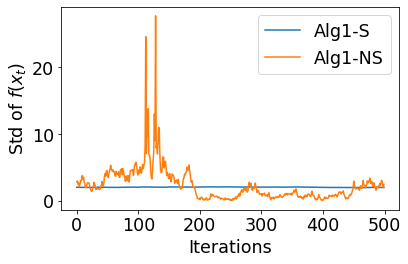

In [746]:
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams['font.size'] = 17.5

l_s, = plt.plot(np.std( ds_stablized, axis = 0 ), label = 'Alg1-S') 
l, = plt.plot(np.std( ds_unstablized, axis = 0 ), label = 'Alg1-NS') 

plt.xlabel('Iterations')

plt.ylabel('Std of $f (x_t)$')

plt.legend( handles = [l_s, l] ) 

plt.tight_layout()

plt.savefig('variance.png', dpi = 150) 

# plt.xlim(-5,500) 

In [448]:
A = np.random.uniform(-3, 3, size = (3,3) ) 

A = np.dot(A, A.T) 

In [449]:


logm( A ) 

array([[ 0.28486543, -0.13200309,  1.15477038],
       [-0.13200309,  1.62187669,  0.37042106],
       [ 1.15477038,  0.37042106,  2.05864801]])

In [5]:
x = sym.Symbol('x')
# y = sym.Symbol('y')

# sym.expand((x + y) ** 3)

x**3 + 3*x**2*y + 3*x*y**2 + y**3

In [15]:
A = sym.Matrix([[1./2 - x, -x], [-x, 1./2]]) 
B = sym.Matrix([[1./2, -x], [-x, 1./2 - x]]) 

one = sym.Matrix([[1.], [1]])

In [22]:
sym.simplify( sym.simplify( A.inv() * one - B.inv() * one )[0] - sym.simplify( A.inv() * one - B.inv() * one )[1] )

-1.0*x/(0.5*x**2 + 0.25*x - 0.125)